## Introduction to Project

Business Case - A new streaming company, LiveWire, is beginning to understand the market that has the majority of its viewers utilizing streaming systems such as: Netflix, Amazon Prime, and Hulu. LiveWire needs the help of a Data Scientist to understand what movies are best to include in its library that are appealing to a wide variety of viewers and needs a recommendation system like these other large brand names have to keep the consumer engaged and interested with their product.

Questions to answer throughout the modeling project:

    1. What are the top 5 genres that should be focused on when adding to the library?
    2. How can a similar user help the recommendation system suggest movies to a new user?
    3. What are the top ten movies of all time based off this DataFrame being utilized?

In [1]:
!conda install surprise


CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://repo.anaconda.com/pkgs/main/osx-64/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.

If your current network has https://www.anaconda.com blocked, please file
a support request with your network engineering team.

'https://repo.anaconda.com/pkgs/main/osx-64'




In [2]:
# !pip install surprise

## Importing Libraries

In [3]:
# import libraries
import numpy as np
import pandas as pd

from surprise import Dataset, Reader
from surprise import KNNBaseline, SVD, SVDpp, NMF
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

## EDA

In [4]:
df1 = pd.read_csv('movies.csv')
df1.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df2 = pd.read_csv('ratings.csv')
df2

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [6]:
df2.columns = ['userId', 'movieId', 'rating', 'timestamp']
df2.head(10)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
5,1,1590,2.5,1256677236
6,1,1591,1.5,1256677475
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
9,1,2840,3.0,1256677500


In [7]:
print(df2['rating'].hist(bins=9))

AxesSubplot(0.125,0.11;0.775x0.77)


In [8]:
# Creating one df with the two seperate df's
df = df2.merge(df1,how='left', left_on='movieId', right_on='movieId')
df.drop_duplicates(inplace=True)
df

,userId,movieId,rating,timestamp,title,genres
0,1,307,3.5,1256677221,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,1,481,3.5,1256677456,Kalifornia (1993),Drama|Thriller
2,1,1091,1.5,1256677471,Weekend at Bernie's (1989),Comedy
3,1,1257,4.5,1256677460,Better Off Dead... (1985),Comedy|Romance
4,1,1449,4.5,1256677264,Waiting for Guffman (1996),Comedy
...,...,...,...,...,...,...
27753439,283228,8542,4.5,1379882795,"Day at the Races, A (1937)",Comedy|Musical
27753440,283228,8712,4.5,1379882751,My Favorite Wife (1940),Comedy|Romance
27753441,283228,34405,4.5,1379882889,Serenity (2005),Action|Adventure|Sci-Fi
27753442,283228,44761,4.5,1354159524,Brick (2005),Crime|Drama|Film-Noir|Mystery


In [9]:
# Creating df based on movie ID's as the index
avg_rating = df.groupby('movieId').mean()
avg_rating

,userId,rating,timestamp
movieId,,,
1,141939.237859,3.886649,1.128094e+09
2,142395.293962,3.246583,1.105961e+09
3,140371.877575,3.173981,9.692933e+08
4,140527.990632,2.874540,9.405874e+08
5,141254.322735,3.077291,9.970812e+08
...,...,...,...
193876,103565.000000,3.000000,1.537875e+09
193878,176871.000000,2.000000,1.537875e+09
193880,81710.000000,2.000000,1.537886e+09


AxesSubplot(0.125,0.125;0.775x0.755)


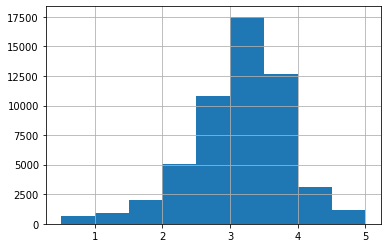

In [10]:
print(avg_rating['rating'].hist(bins=9))

In [11]:
# Adding the title into the new df and dropping irrelevant column 'timestamp'
df_avg_rtng = avg_rating.merge(df1, right_index=True, left_on='movieId')
df_avg_rtng = df_avg_rtng.drop(columns='timestamp')
df_avg_rtng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12485 entries, 1 to 58094
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   12485 non-null  float64
 1   rating   12485 non-null  float64
 2   movieId  12485 non-null  int64  
 3   title    12485 non-null  object 
 4   genres   12485 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 585.2+ KB


In [12]:
# Ensuring there are no duplicate values within the df
df_avg_rtng.drop_duplicates(inplace=True)
df_avg_rtng.shape

(12485, 5)

In [13]:
# Separating genres to categorical valuesb
dummies = df_avg_rtng['genres'].str.get_dummies(sep='|')
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12485 entries, 1 to 58094
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   (no genres listed)  12485 non-null  int64
 1   Action              12485 non-null  int64
 2   Adventure           12485 non-null  int64
 3   Animation           12485 non-null  int64
 4   Children            12485 non-null  int64
 5   Comedy              12485 non-null  int64
 6   Crime               12485 non-null  int64
 7   Documentary         12485 non-null  int64
 8   Drama               12485 non-null  int64
 9   Fantasy             12485 non-null  int64
 10  Film-Noir           12485 non-null  int64
 11  Horror              12485 non-null  int64
 12  IMAX                12485 non-null  int64
 13  Musical             12485 non-null  int64
 14  Mystery             12485 non-null  int64
 15  Romance             12485 non-null  int64
 16  Sci-Fi              12485 non-null  int6

In [14]:
print('Number of Users: ', len(df['userId'].unique()))
# print('Number of Movies in each Genre: ', for x in dummies)...

Number of Users:  283228


In [15]:
df['rating'].value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

In [16]:
dummies.astype(int).astype(str)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
58078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
58081,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [18]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12485 entries, 1 to 58094
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   (no genres listed)  12485 non-null  int64
 1   Action              12485 non-null  int64
 2   Adventure           12485 non-null  int64
 3   Animation           12485 non-null  int64
 4   Children            12485 non-null  int64
 5   Comedy              12485 non-null  int64
 6   Crime               12485 non-null  int64
 7   Documentary         12485 non-null  int64
 8   Drama               12485 non-null  int64
 9   Fantasy             12485 non-null  int64
 10  Film-Noir           12485 non-null  int64
 11  Horror              12485 non-null  int64
 12  IMAX                12485 non-null  int64
 13  Musical             12485 non-null  int64
 14  Mystery             12485 non-null  int64
 15  Romance             12485 non-null  int64
 16  Sci-Fi              12485 non-null  int6

In [19]:
dummies_obj = dummies.astype('object')

In [20]:
df_dummies = df_avg_rtng.merge(dummies_obj, left_index=True, right_on='movieId')
df = df_dummies.drop(['genres'], axis=1)
df

,userId,rating,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,141939.237859,3.886649,2,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,142395.293962,3.246583,3,Grumpier Old Men (1995),0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,140371.877575,3.173981,4,Waiting to Exhale (1995),0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,140527.990632,2.874540,5,Father of the Bride Part II (1995),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,141254.322735,3.077291,6,Heat (1995),0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,139770.200000,3.900000,193809,The Stone Killer (1973),0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58078,146224.153595,3.315359,193845,Dywizjon 303 (2018),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58081,95994.666667,3.500000,193853,Wu Kong (2017),0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print(df_dummies.columns)
df_dummies.info()

Index(['userId', 'rating', 'movieId', 'title', 'genres', '(no genres listed)',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12485 entries, 1 to 58094
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userId              12485 non-null  float64
 1   rating              12485 non-null  float64
 2   movieId             12485 non-null  int64  
 3   title               12485 non-null  object 
 4   genres              12485 non-null  object 
 5   (no genres listed)  12485 non-null  object 
 6   Action              12485 non-null  object 
 7   Adventure           12485 non-null  object 
 8   Animation           12485 non-null  object 
 9   Children   

In [22]:
df.rename(columns={"(no genres listed)": "None Listed"})
df

,userId,rating,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,141939.237859,3.886649,2,Jumanji (1995),0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,142395.293962,3.246583,3,Grumpier Old Men (1995),0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,140371.877575,3.173981,4,Waiting to Exhale (1995),0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,140527.990632,2.874540,5,Father of the Bride Part II (1995),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,141254.322735,3.077291,6,Heat (1995),0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,139770.200000,3.900000,193809,The Stone Killer (1973),0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58078,146224.153595,3.315359,193845,Dywizjon 303 (2018),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58081,95994.666667,3.500000,193853,Wu Kong (2017),0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Spliting the Dataset


In [23]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [24]:
# train-test split
train, test = train_test_split(data, test_size=.2)

In [25]:
train

## Testing Models

In [26]:
KNNB = KNNBaseline()
KNNB.fit(train)
predictions_1 = KNNB.test(test)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [27]:
accuracy.rmse(predictions_1)

RMSE: 0.5119


0.5118937312672807

In [28]:
SVD = SVD()
SVD.fit(train)
predictions_2 = SVD.test(test)

In [29]:
accuracy.rmse(predictions_2)

RMSE: 0.5119


0.5118948252392272

In [30]:
SVDpp = SVDpp()
SVDpp.fit(train)
predictions_3 = SVDpp.test(test)

In [31]:
accuracy.rmse(predictions_3)

RMSE: 0.5119


0.5118986354172084

In [32]:
NMF = NMF()
NMF.fit(train)
predictions_4 = NMF.test(test)

In [33]:
accuracy.rmse(predictions_4)

RMSE: 0.5119


0.5118945140117823

## Making initial Prediction

In [34]:
uid = str(100)
iid= str(400)

pred = SVD.predict(uid, iid, r_ui=4, verbose=True)

user: 100        item: 400        r_ui = 4.00   est = 3.19   {'was_impossible': False}


## Fine Tuning Preferred Model

In [35]:
# param_grid = {
#     'n_factors':[5, 10,20],
#     'n_epochs': [5, 10, 20], 
#     'lr_all': [0.002, 0.005],
#     'reg_all': [0.4, 0.6]}

In [37]:
final = SVD(n_epochs=10, n_factors=1, biased=True, lr_all=0.002, reg_all=0.4)

TypeError: 'SVD' object is not callable

In [ ]:
final.fit(train)

In [ ]:
predictions = final.test(test)

In [ ]:
predictions[:3]

In [ ]:
accuracy.rmse(predictions)


## Recommendations for User

In [ ]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Then predict ratings for all pairs (u, i) that are NOT in the training set.
test = train.build_anti_testset()
predictions = SVD.test(test)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    
# Source of this block of code: https://surprise.readthedocs.io/en/stable/FAQ.html

## Scrap Code

In [ ]:
# param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#               'reg_all': [0.4, 0.6]}
# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# gs.fit(test)

# # best RMSE score
# print(gs.best_score['rmse'])

# # combination of parameters that gave the best RMSE score
# print(gs.best_params['rmse'])

In [ ]:
# gs_model.fit(df)